# Regression + regularization mini-tutorial - Prediction of neural activity from animal behavior observations

## Background

In this set of exercises we will try to predict the neural activity from videos of animal behavior using ridge-regression. The data we will use come from a larger dataset published here: https://science.sciencemag.org/content/364/6437/eaav7893. For the data here, the mouse was not doing a task, and was free to run and whisk and groom as it pleased. In the meantime there was random noise shown on the screen in front of the mouse.

The neural data consists of the activity of excitatory neurons in visual cortex recorded using two-photon calcium imaging. For these exercises it has been pre-processed. There were originally 5439 neurons, but here we have reduced that to the top 256 principal components sampled at 1Hz.

The behavioral data was recorded for the same period. While the mouse was on the microscope, we captured its face on video and took the top 500 PCs of the motion energy of this video data, sampled at 1Hz.

This particular group of neurons have been classified as NOT stimulus-selective, so we are interested in understanding what they are doing. The motivation for this regression analysis is to investigate whether the neural activity is explained by mouse behavior.


A fragment of sample neural activity is as shown below. 

<img src="signal.png">

# Set up python packages and load data

In [0]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6ocezziz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6ocezziz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.09a04bc004009599225a544fb4e02c7279edc4418_-cp36-none-any.whl size=113073 sha256=e76becd16d912261d4acd2665fb45f8a383bfe6339b8c484bc65a69119dc55f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ot9wkgy/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import tensorflow as tf
from keras import regularizers

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.math import reduce_sum

# This cell imports all the functions and data we need.
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function for gaussian_filtering
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
import urllib
%matplotlib inline 

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading Data

We are now loading data as a npy file. The two neural activities that're monitored here are: 
A. 2 photon neural activity 
B. Video of mouse's face during behavior projected onto top 500 principal components.

In [0]:
# download 2-photon data

with urllib.request.urlopen('https://github.com/kbonnen/NeuromatchTeachingDemo/raw/master/teaching-demo-data.npy') as response:
    with open('teaching-demo-data.npy','wb') as f:
        f.write(response.read())

data = np.load('teaching-demo-data.npy',allow_pickle=True).item()

# Extract the data into variables
neural_reduced = zscore(data['neural_reduced'], axis=1) # 2-photon neural activity with mean 0 and standard deviation, collected at 3Hz
behavior_reduced = data['behavior_reduced'] # video of the mouse's face during behavior projected onto the top 500 principal components

In [0]:
# Examine the data a bit:
print('neural data: ' + str(neural_reduced.shape[0]) + ' neural components x ' + str(neural_reduced.shape[1]) + ' time points (seconds)')
print('behavioral data: ' + str(behavior_reduced.shape[0]) + ' behavioral components x ' + str(behavior_reduced.shape[1]) + ' time points (seconds)')

neural data: 256 neural components x 3333 time points (seconds)
behavioral data: 500 behavioral components x 3333 time points (seconds)


In [0]:
print(neural_reduced)

[[ 0.5799147   1.4994344   0.76891106 ... -0.12465913  0.10321835
   0.22783925]
 [-1.540894   -2.3608732  -2.423194   ...  0.371131    1.002064
   0.7579882 ]
 [ 0.22418395  2.476006    1.3415462  ... -0.9539228  -1.3198861
  -1.2574    ]
 ...
 [-2.3788247   1.3768593   1.6034116  ... -0.6645684   0.7635423
   2.6562564 ]
 [-0.3166012   0.09858608 -1.9884852  ...  0.72511727 -0.65573883
  -1.2849753 ]
 [-2.0788105  -0.19527477 -0.85495    ...  0.08488157 -1.3931931
   0.5731896 ]]


In [0]:
print(behavior_reduced)

[[-1.1529003e+03 -9.6382648e+02 -9.7400739e+02 ...  7.7480933e+02
   7.7468488e+02  7.7517462e+02]
 [ 1.1538864e+02  3.6153748e+00  7.4189545e+01 ...  3.2519070e+01
   3.2732010e+01  3.2649868e+01]
 [-2.2078624e+02 -2.7110422e+02 -2.5615170e+02 ... -6.4847572e+01
  -6.5246803e+01 -6.5208801e+01]
 ...
 [-5.4275093e+00  4.2419262e+00  1.2525138e+01 ...  1.1637942e+00
   9.7476357e-01  1.0323842e+00]
 [ 5.0994892e+00  1.3616038e+01  6.2771049e+00 ...  1.9769324e+00
   1.9919386e+00  2.1725113e+00]
 [ 2.8838384e+00 -8.0461025e-01  1.9235568e+00 ... -1.4633934e-01
  -5.8409244e-01 -6.2646836e-01]]


# Prediction of Neural principal components using Behavioral principal components

## Test-train split

We opt for interleaved segment based split on neural components as there's correlation on the time axis and we need to ensure that data is independent to avoid overfitting. 

<img src="split.png">

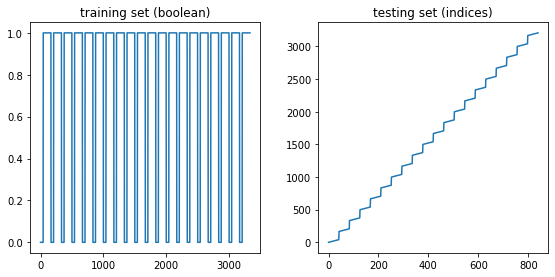

In [0]:
# Split the data into train and test sets
# *** use interleaved segments ***
nsegs = 20
nt = neural_reduced.shape[1]
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

fig=plt.figure(figsize=(8,4))
ax = fig.add_axes([0,.05,.4,.8])
ax.plot(itrain)
ax.set_title("training set (boolean)")

ax = fig.add_axes([0.5,.05,.4,.8])
ax.plot(itest)
ax.set_title("testing set (indices)")
plt.show()


# Data Visualization

Text(0.5, 1.0, 'Plotting Observed Behavior')

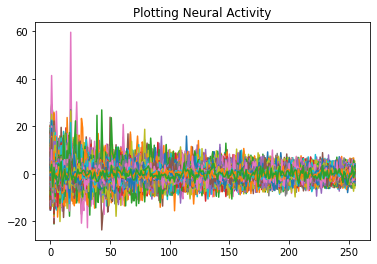

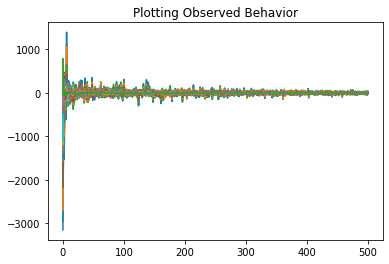

In [0]:
fig, ax = plt.subplots()
ax.plot(data["neural_reduced"])
# set title and legend
ax.set_title('Plotting Neural Activity')

fig, ax = plt.subplots()
ax.plot(data["behavior_reduced"])
# set title and legend
ax.set_title('Plotting Observed Behavior')

## Data Analysis
It's first important to recognise the variables before we start coding into this aspect. 

We know that X_Train refers to the training data. 
In our case as per the problem statement, we're trying to predict the neural activity from animal behavior observations which means that our target/label is neural_reduced variable and hence, our X_train should be the behavior_reduced variable. 

Let us try to understand the mathematics behind these operations in a little more detail. 


In [0]:
print(behavior_reduced.shape)

(500, 3333)


In [0]:
print(neural_reduced.shape)

(256, 3333)


In [0]:
print(behavior_reduced[:,itrain].shape)
print(behavior_reduced[:,itest].shape)

(500, 2493)
(500, 840)


## Linear Regression

Now use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

where $X$ is the reduced behavioral data and $Y$ is the reduced neural data

Then the prediction is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

Let us try and visualise this process so as to gain clarity about our perception. 

First, let's split our "A" into parts. XXt is the covariance matrix. 
By definition, in probability theory and statistics, a covariance matrix is a square matrix giving the covariance between each pair of elements of a given random vector. 

<img src="covarxxt.png">

The second part of "A" corresponds to the covariance between train variable X_train and target variable. By definition, covariance refers to the measure of the joint variability of two random variables. If the greater values of one variable mainly correspond with the greater values of the other variable, and the same holds for the lesser values, the covariance is positive.



<img src="covarxyt.png">

Our weight matrix "A" is hence a combination of the result of above two matrices. 

<img src="a.png">

We finally need to perform the final prediction. 

<img src="prediiction.png">

We can now go ahead and code the above. There are multiple ways of doing the same. Two are shown below. 

# Tensorflow-keras based code

#### Explanation:

tf.matmul()    
for matrix multiplication
 
object.transpose() and tf.transpose(object)    
for matrix transpose (NOTE: check tensorflow version. Order of operations might matter. Check documentation for more details: https://www.tensorflow.org/api_docs)




In [0]:

XXt = tf.matmul(behavior_reduced[:, itrain], behavior_reduced[:, itrain].transpose())
XYt = tf.matmul(behavior_reduced[:, itrain], neural_reduced[:, itrain].transpose())
A = tf.linalg.solve(XXt, XYt)

Yhat_linear = tf.matmul(tf.transpose(A), behavior_reduced[:, itest])
Yhat_train_linear = tf.matmul(tf.transpose(A), behavior_reduced[:, itrain])

# Calculate the proportion of variance explained.
varexp_linear_tf = 1 - (reduce_sum(((Yhat_linear - neural_reduced[:,itest])**2), axis=1)/reduce_sum((neural_reduced[:,itest]**2),axis=1))
print(varexp_linear_tf)

tf.Tensor(
[ 0.26193172 -0.07701683  0.13011944 -0.02597868  0.12560606 -0.4591701
  0.10348815 -0.2192024   0.04500574 -0.35865057 -0.33568585 -0.4360658
 -0.39736223 -0.6342344  -0.11702573 -0.29057848 -0.2657572  -1.2778406
 -0.42759657 -0.36836338 -0.39501154 -0.1866368  -0.58315253 -0.34797144
 -0.37728143 -0.46025825 -0.5582322  -0.42369604 -0.36837018 -0.4591794
 -0.6922349  -0.3987726  -0.3615321  -0.4822414  -0.4543401  -0.5413438
 -0.49612987 -0.5326086  -0.45679116 -0.47166264 -0.4484043  -0.33836865
 -0.4123466  -0.35680377 -0.4800092  -0.5656117  -0.41475344 -0.6108098
 -0.346941   -0.6075753  -0.33288813 -0.35440993 -0.48588943 -0.37986147
 -0.5411705  -0.45913517 -0.609671   -0.48251724 -0.37923288 -0.48661256
 -0.5149399  -0.32069182 -0.40848112 -0.3327514  -0.32959974 -0.5585557
 -0.33010495 -0.59412503 -0.4172367  -0.5826912  -0.4904915  -0.43414998
 -0.56753623 -0.3404225  -0.5997174  -0.427554   -0.6047505  -0.35745466
 -0.61190367 -0.6958542  -0.46330178 -0.7797557

# Numpy based code

#### Explanation:

np.matmul()   
for matrix multiplication
 
object.T       
for matrix transpose

np.linalg.solve()
for factorization of variable_1 using LU decomposition and then solves the equation using forward and backward substitution. Note that this method is more efficient than explicit inverse() as the latter incurs more floating point operations. 



In [0]:
XXt = np.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].T)
XYt = np.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].T) 
A = np.linalg.solve(XXt, XYt )

Yhat_linear = np.matmul(A.T, behavior_reduced[:,itest]) 
Yhat_train_linear = np.matmul(A.T, behavior_reduced[:,itrain]) 


# Calculate the proportion of variance explained.
varexp_linear_np = 1 - ((Yhat_linear - neural_reduced[:,itest])**2).sum(axis=1)/(neural_reduced[:,itest]**2).sum(axis=1)
print(varexp_linear_np)

[ 0.2619294  -0.07701743  0.13011974 -0.02598202  0.125606   -0.45917046
  0.10348922 -0.21920192  0.04500562 -0.35864902 -0.3356874  -0.43606675
 -0.3973614  -0.6342348  -0.11702502 -0.29057932 -0.26575947 -1.2778466
 -0.42759514 -0.36836457 -0.39501238 -0.18663764 -0.58315    -0.34797454
 -0.37728262 -0.46025765 -0.5582342  -0.42369556 -0.36836958 -0.45918047
 -0.69223344 -0.3987708  -0.36153126 -0.4822415  -0.45434117 -0.54134214
 -0.49613106 -0.53260934 -0.45679295 -0.4716611  -0.4484049  -0.33837092
 -0.41234756 -0.35680425 -0.48001266 -0.5656134  -0.4147551  -0.6108091
 -0.34693968 -0.6075772  -0.33288884 -0.35440946 -0.48588932 -0.37986183
 -0.5411695  -0.45913625 -0.60967255 -0.48251534 -0.37923336 -0.486611
 -0.5149423  -0.32069278 -0.40848267 -0.3327514  -0.32959914 -0.5585555
 -0.33010566 -0.594126   -0.41723824 -0.58269143 -0.49049377 -0.4341489
 -0.5675323  -0.34042287 -0.59971774 -0.42755306 -0.604751   -0.35745573
 -0.6119051  -0.6958537  -0.46330166 -0.7797576  -0.45997

# Visualization of Principal component activity and variance

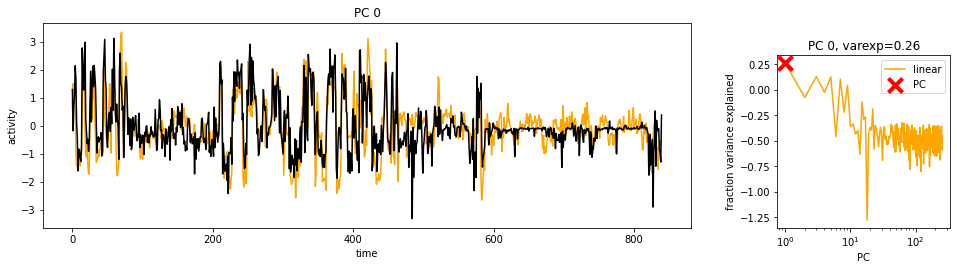

In [0]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which neural PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(neural_reduced[ipc,itest],color="orange")
ax.plot(Yhat_linear[ipc], color="black")
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_linear_np[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_linear_np.size+1), varexp_linear_np, color="orange")
ax.legend(['linear','PC'])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_linear_np[ipc]))
plt.show()



We can now apply regularisation in order to control overfitting. 

## Ridge Regression

Now let's regularize the linear regression using the L2-norm (a.k.a. ridge regression):

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction is still:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$


Let us try and visualise this process so as to gain clarity about our perception. 

First, let's split our "A" into parts. XXt is the covariance matrix and to this we add our regularisation coefficient. 
As defined earlier, a covariance matrix is a square matrix giving the covariance between each pair of elements of a given random vector. 

Below, we know the dimension of identity matrix I implicity because by rules of matrix addition, we can perform such arithmetic operations only matrices of the same dimension. 

<img src="rxxt.png">

The second part of "A" corresponds to the covariance between train variable X_train and target variable. By definition, covariance refers to the measure of the joint variability of two random variables. If the greater values of one variable mainly correspond with the greater values of the other variable, and the same holds for the lesser values, the covariance is positive.



<img src="covarxyt.png">

Our weight matrix "A" is hence a combination of the result of above two matrices. 

<img src="a.png">

We finally need to perform the final prediction. 


<img src="prediiction.png">

We can now go ahead and code. There are multiple ways of doing the same. Two are shown below. 

## Choice of K or lambda
Through the parameter λ we can control the impact of the regularization term. Higher values lead to smaller coefficients, but too high values for λ can lead to underfitting.

# Tensorflow - Keras based code

#### Explanation:

tf.matmul()    
for matrix multiplication
 
object.transpose() and tf.transpose(object) 
for matrix transpose (NOTE: check tensorflow version. Order of operations might matter. Check documentation for more details: https://www.tensorflow.org/api_docs)




In [0]:
XXt = tf.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].transpose())  
lam = 1e6
XXt += lam * tf.eye(behavior_reduced.shape[0])
XYt = tf.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].transpose())  
A = tf.linalg.solve(XXt, XYt )

Yhat_ridge = tf.matmul(tf.transpose(A), behavior_reduced[:,itest])  
Yhat_train_ridge = tf.matmul(tf.transpose(A), behavior_reduced[:,itrain])

# Calculate the proportion of variance explained.
varexp_ridge_tf = 1 - (reduce_sum(((Yhat_ridge - neural_reduced[:,itest])**2), axis=1)/reduce_sum((neural_reduced[:,itest]**2),axis=1))
print(varexp_ridge_tf)

tf.Tensor(
[ 5.06705225e-01  2.41796851e-01  3.49693358e-01  2.17619598e-01
  3.37800145e-01  1.06121242e-01  2.40024984e-01  1.07774496e-01
  3.27759087e-01  5.59012890e-02  4.69311476e-02  5.76687455e-02
  6.70188665e-02 -1.66510344e-02  1.38991892e-01  1.09228253e-01
  6.59138560e-02 -7.11655617e-03  8.47014785e-02  6.53796792e-02
  9.56988335e-03  4.56486940e-02  2.76145339e-02  2.21752524e-02
  2.91055441e-02  8.23017955e-02 -5.01596928e-03  1.64403319e-02
  5.28088808e-02 -1.25479698e-03  1.00496411e-02  3.06401849e-02
  3.89324427e-02  6.36289716e-02  6.81418180e-03  5.97597957e-02
  1.84361935e-02  4.12763357e-02 -4.33671474e-03 -4.72997427e-02
 -2.06232071e-02  1.30281448e-02  3.02512646e-02  3.41973305e-02
  1.76047087e-02  7.94637203e-03  2.73048878e-03 -2.33762264e-02
  1.09971166e-02 -3.83797884e-02  1.82668567e-02  8.33272934e-05
 -5.02673388e-02 -3.78739834e-03 -6.70117140e-02 -4.25890684e-02
 -1.58556700e-02 -3.03934813e-02  1.35256648e-02  2.00765729e-02
 -1.63565874e-

# Numpy based code

#### Explanation:

np.matmul()      
for matrix multiplication
 
object.T        
for matrix transpose

np.linalg.solve()
for factorization of variable_1 using LU decomposition and then solves the equation using forward and backward substitution. Note that this method is more efficient than explicit inverse() as the latter incurs more floating point operations. 



In [0]:
XXt = np.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].T) 
lam = 1e6 
XXt += lam*np.eye(behavior_reduced.shape[0]) 
XYt = np.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].T)  
A = np.linalg.solve(XXt, XYt )

Yhat_ridge = np.matmul(A.T, behavior_reduced[:,itest]) 
Yhat_train_ridge = np.matmul(A.T, behavior_reduced[:,itrain])

# Calculate the proportion of variance explained.
varexp_ridge = 1 - ((Yhat_ridge - neural_reduced[:,itest])**2).sum(axis=1)/(neural_reduced[:,itest]**2).sum(axis=1)
print(varexp_ridge)

[ 5.06705165e-01  2.41796672e-01  3.49694133e-01  2.17619121e-01
  3.37800205e-01  1.06120944e-01  2.40025461e-01  1.07774377e-01
  3.27759027e-01  5.59018254e-02  4.69309092e-02  5.76686263e-02
  6.70198202e-02 -1.66507959e-02  1.38992310e-01  1.09228253e-01
  6.59135580e-02 -7.11643696e-03  8.47021937e-02  6.53797388e-02
  9.56928730e-03  4.56486344e-02  2.76147127e-02  2.21740603e-02
  2.91052461e-02  8.23014379e-02 -5.01644611e-03  1.64401531e-02
  5.28087020e-02 -1.25598907e-03  1.00504756e-02  3.06411386e-02
  3.89322639e-02  6.36292696e-02  6.81388378e-03  5.97600341e-02
  1.84366107e-02  4.12765741e-02 -4.33731079e-03 -4.72998619e-02
 -2.06235647e-02  1.30279064e-02  3.02512646e-02  3.41970325e-02
  1.76047087e-02  7.94601440e-03  2.73078680e-03 -2.33764648e-02
  1.09971762e-02 -3.83797884e-02  1.82667971e-02  8.33272934e-05
 -5.02665043e-02 -3.78704071e-03 -6.70109987e-02 -4.25893068e-02
 -1.58560276e-02 -3.03932428e-02  1.35252476e-02  2.00765729e-02
 -1.63568258e-02 -1.75232

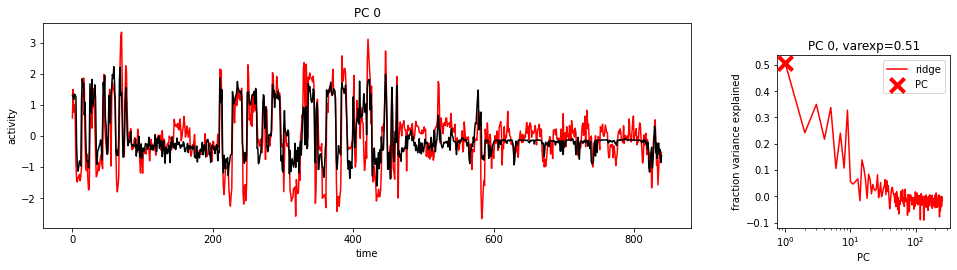

In [0]:
XXt = np.matmul(behavior_reduced[:,itrain], behavior_reduced[:,itrain].T)  # SOLUTION
lam = 1e6 # regularizer # SOLUTION
XXt += lam*np.eye(behavior_reduced.shape[0]) # SOLUTION
XYt = np.matmul(behavior_reduced[:,itrain], neural_reduced[:,itrain].T)  
A = np.linalg.solve(XXt, XYt )

Yhat_ridge = np.matmul(A.T, behavior_reduced[:,itest])  # SOLUTION
Yhat_train_ridge = np.matmul(A.T, behavior_reduced[:,itrain]) # SOLUTION

# Calculate the proportion of variance explained.
varexp_ridge = 1 - ((Yhat_ridge - neural_reduced[:,itest])**2).sum(axis=1)/(neural_reduced[:,itest]**2).sum(axis=1)

# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(neural_reduced[ipc,itest],color="red")
ax.plot(Yhat_ridge[ipc], color="black")
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color="red")
ax.legend(['ridge','PC'])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
plt.show()


# Comparison of analysis!

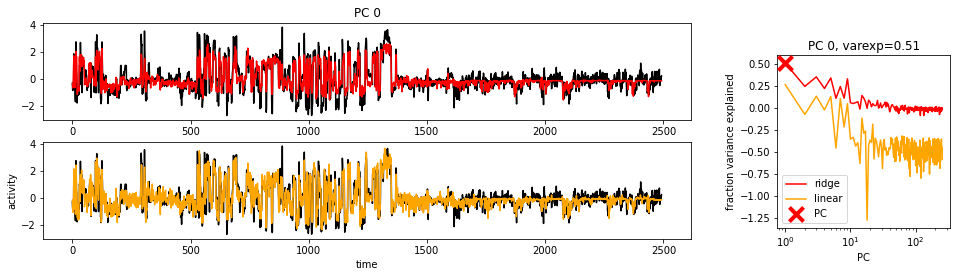

In [0]:
# plot of principal component activity from the training set and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

# Plot Yhat for the training set for ridge regression
ax = fig.add_axes([0.05,.55,.75,.45])
ax.plot(neural_reduced[ipc,itrain],color=[0,0,0])
ax.plot(Yhat_train_ridge[ipc], color="red")
ax.set_title('PC %d'%ipc)

# Plot Yhat for the training set for linear regression
ax = fig.add_axes([0.05,0,.75,.45])
ax.plot(neural_reduced[ipc,itrain],color=[0,0,0])
ax.plot(Yhat_train_linear[ipc],  color="orange")
ax.set_xlabel('time')
ax.set_ylabel('activity')

# Plot the variance explained
ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color="red")
ax.semilogx(np.arange(1,varexp_linear_np.size+1), varexp_linear_np, color="orange")
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
ax.legend(['ridge','linear','PC'])
plt.show()